In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Proposal 

    I will be analyzing data provided by Vice News about Police Involved shootings across the U.S. The source of the data and raw data can be accessed at this site: https://news.vice.com/en_us/article/a3jjpa/nonfatal-police-shootings-data. Vice collected the data, which is information about shootings involving police, both fatal and non-fatal, from the 50 largest Police Precincts in the U.S. I will attempt to build a model(s) that accurately categorize whether a shooting is fatal or non. Of the most interest to me is the contributing factors, because I am confident that by looking at the coefficients I can get an accurate picture of how the situations differ between Fatal and Non-Fatal instances of police discharging their weapons. With this information, I hope to be able to make recommendations to police departments about actions they can take to minimize the chances of killing their suspects. 
    
    I understand that the Police do their best to protect people, and themselves, from dangerous criminals and that they deal with dangerous situations on a daily basis and are constantly trying to balance apprehending a criminal and making sure that they don't get hurt themselves in the process. With this data I hope to be able to provide valuable information about how Police officers can approach these situations to minimize the chances of anyone dying. 
    
If we can predict why fatalities happen, maybe we can help reduce the likelihood of them occurring. 

# Imports

In [2]:
import pandas as pd
import seaborn as sns
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.compose import ColumnTransformer
from category_encoders import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.calibration import calibration_curve

from sklearn.feature_selection import SelectKBest, f_classif

from functions_pkg import print_vif, predictions_df

from xgboost import XGBClassifier

from mlxtend.plotting import plot_decision_regions

import skimage.io
import wordcloud


%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# function used for finding the VIF, provided by Adam


def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
# Load in Data
path = "https://raw.githubusercontent.com/WoodyBurns44/thinkful/main/ViceNews_FullOISData%20-%20Sheet1.csv"

df = pd.read_csv(path)

<IPython.core.display.Javascript object>

In [5]:
df.head(2)

,Date,NumberOfSubjects,Fatal,SubjectArmed,SubjectRace,SubjectGender,SubjectAge,NatureOfStop,NumberOfShots,NumberOfOfficers,OfficerRace,OfficerGender,Department,FullNarrative,City,Notes
0,3/4/2010,1,N,N,L,U,U,NaN,NaN,1,W,M,Albuquerque Police Department,NaN,Albuquerque,motorized vehicle; no hits
1,1/9/2010,1,F,Y,W,M,U,NaN,NaN,1,W,M,Albuquerque Police Department,NaN,Albuquerque,NaN


<IPython.core.display.Javascript object>

In [6]:
# Seperate descriptive columns for language analysis
language_df = df[["Fatal", "NatureOfStop", "FullNarrative", "Notes"]]

<IPython.core.display.Javascript object>

In [7]:
# Drop language categories
# Drop Number of Subjects, redundant because all values are 1.
df = df.drop(columns=["NatureOfStop", "FullNarrative", "Notes", "NumberOfSubjects"])

<IPython.core.display.Javascript object>

## Data Cleaning, exploration, and feature engineering

In [8]:
# TODO: Cleaning and preperation
# - 'Date' - extract year, month, maybe drop - *
# - 'NumberOfSubjects' is redundant, all values are 1 - *
# - 'Fatal' - Standardize Values - *
# - 'SubjectArmed' - Standardize Values - *
# - 'SubjectRace' - Deal with na's - *
# - 'SubjectGender' - deal with 2 na's - *
# - 'SubjectAge' - deal with 3 na's, group by 10 years - *
# - 'NatureOfStop' - Create "Other" value, deal with high # of NA's
# - 'NumberOfShots' - combine when multiple officers are involved - *
# - 'NumberOfOfficers' - standardize values and group - *
# - 'OfficerRace' - Create "multiple Officer value", create 'minority officer involved' variable
# - 'OfficerGender' - Standadize and create 'multiple_officer' and 'female present' cats
# - 'Department' - Redundant, since city is listed
# - 'FullNarrative' - NLP? Has FN? SKLEARN.feature_extraction.text TFIDF vectorizer
# - 'City' - Might be redundant, Check out in EDA, drop for model
# - 'Notes' - What to do with them, maybe do some NLP

# Wordclouds - Fatal and Not Fatal

<IPython.core.display.Javascript object>

### Target Variable - Fatal

In [9]:
# Cleaning N and F with spaces
df["Fatal"].replace({" N": "N", " F": "F"}, inplace=True)
# Since Fatality is target, Dropping Rows where Fatality is unknown
unknown_fatals = df[df["Fatal"] == "U"].index
df = df.drop(unknown_fatals, axis=0)

<IPython.core.display.Javascript object>

### Date

In [10]:
# Convert to datetime format
df["Date"] = pd.to_datetime(df["Date"])
# Extract Year and Month
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
# Drop original Date column
df = df.drop(columns="Date")

<IPython.core.display.Javascript object>

### Subject Armed

In [11]:
df["SubjectArmed"].value_counts()
# Fix syntatical issues
df["SubjectArmed"].replace("Y ", "Y", inplace=True)
# Filling Nan values with U for Unknown
df["SubjectArmed"] = df["SubjectArmed"].fillna("U")

<IPython.core.display.Javascript object>

### Subject Race

In [12]:
df["SubjectRace"].isna().sum()
df["SubjectRace"] = df["SubjectRace"].fillna("U")
df["SubjectRace"].value_counts()

B    1604
U    1152
L     667
W     637
A      38
O      14
Name: SubjectRace, dtype: int64

<IPython.core.display.Javascript object>

### Subject Gender


In [13]:
# df[df['SubjectGender'] == 'M;U']
df["SubjectGender"].replace("M;U", "M", inplace=True)

<IPython.core.display.Javascript object>

### Subject Age

In [14]:
# df["SubjectAge"].unique()
# df[df['SubjectAge'] == '20-29']
# df[df['SubjectAge'] == '0-19']
# df[df['SubjectAge'] == '30-39']
# df[df['SubjectAge'] == 'Juvenile']

# When age ranges are given, replace with average of range.
# Except for 0-19, which I am treating as 17 year olds because
# after doing some research, that seems like the average age of
# young people involved in incidents. In the case of "Juvenile",
# I set that to 17 as well for the same reason.
df["SubjectAge"].replace(
    {
        "UNKNOWN": "U",
        "0-19": "17",
        "20-29": "25",
        "30-39": "35",
        "40-49": "45",
        "50-59": "55",
        "NaN": "U",
        "Juvenile": "17",
        "21-23": "22",
    },
    inplace=True,
)

df["SubjectAge"].fillna("U", inplace=True)

# df["SubjectAge"].isna().sum()

<IPython.core.display.Javascript object>

### Number of Officers

In [15]:
# When Number of Officers is represented with a '>', I rounded up
# to the nearest number divisible by 2, since officers usually have
# a partner.
# Replaced any instance of zero officers with 1, since there must have been
# at least one officer there.
df["NumberOfOfficers"].replace(
    {
        ">1": 2,
        "2 or multiple_officer": 2,
        ">2": 4,
        ">5": 6,
        ">3": 4,
        ">6": 8,
        ">7": 8,
        "2 or More": 2,
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

### Officer Race

In [16]:
# Transform Officer race variables into binary features
# Indicating which races of officers were involved in the occurance


df.OfficerRace.fillna("U", inplace=True)
races = df.OfficerRace.copy()
races_split = races.str.split(";")
unique_races = []
for race in races_split:
    for val in race:
        if val == "WHITE":
            val = "W"
        blk = ["BLACK", "Other:B", "W:B"]
        if val in blk:
            val = "B"
        api = ["A/PI", "AI/AN", "A/PI Unknown"]
        if val in api:
            val = "A"
        hisp = ["H", "W/H", "W/ H", "H: H", "H/L"]
        if val in hisp:
            val = "L"
        asian = [
            "ASIAN",
            "A/W",
            "W/A",
        ]
        if val in asian:
            val = "A"
        uk = ["Unknown", "Unknown ", "NA", "U "]
        if val in uk:
            val = "U"
        wt = ["W:W", "NA/W"]
        if val in wt:
            val = "W"
        oth = ["I", "m/m", "M", "Multi-Racial"]
        if val in oth:
            val = "O"
        if val in unique_races:
            continue
        else:
            unique_races.append(val)


df["races_split"] = races_split
races_split = df.races_split.to_list()
unique_races[1] = "H"
cats = [
    "White Officer Involved",
    "Latino Officer Involved",
    "officer_U",
    "Black Officer Involved",
    "Asian Officer Involve",
    "Other Race Officer Involved",
]

officers = []
for j in range(len(races_split)):
    off = []
    for race in unique_races:
        if race in races_split[j]:
            off.append(1)
        else:
            off.append(0)
    officers.append(off)


off_df = pd.DataFrame(officers, columns=cats)
# off_df

df.reset_index(inplace=True)

df.drop(columns=["index"], inplace=True)
# df

df = df.join(off_df)
df.drop(columns=["OfficerRace"], inplace=True)
df.head(2)

,Fatal,SubjectArmed,SubjectRace,SubjectGender,SubjectAge,NumberOfShots,NumberOfOfficers,OfficerGender,Department,City,Year,Month,races_split,White Officer Involved,Latino Officer Involved,officer_U,Black Officer Involved,Asian Officer Involve,Other Race Officer Involved
0,N,N,L,U,U,NaN,1,M,Albuquerque Police Department,Albuquerque,2010,3,[W],1,0,0,0,0,0
1,F,Y,W,M,U,NaN,1,M,Albuquerque Police Department,Albuquerque,2010,1,[W],1,0,0,0,0,0


<IPython.core.display.Javascript object>

### Officer Gender

In [17]:
# Fill null Officer gender values with U
df.OfficerGender.fillna("U", inplace=True)
genders = df.OfficerGender.copy()
# Since genders are values sperated by ';', have to split
gender_split = genders.str.split(";")
# Get unique genders and transforms variations of records
# of the same genders
unique_genders = []
for gender in gender_split:
    for val in gender:
        male = ["M", "M ", "M:M", "/M", "Male", "M: M", "MALE", " /M"]
        if val in male:
            val = "M"
        unknwn = ["Unknown", "N", "U", ""]
        if val in unknwn:
            val = "U"
        female = ["F", "W", "FEMALE"]
        if val in female:
            val = "F"
        if val in unique_genders:
            continue
        else:
            unique_genders.append(val)

unique_genders

['M', 'F', 'U']

<IPython.core.display.Javascript object>

In [18]:
# Create list of Officer Genders to work on
df["Officer Genders"] = gender_split
gender_split = df["Officer Genders"].to_list()
cats = ["Male Officer Present", "Female Officer Present", "Unknown Officer Present"]

# Create binary gender variable
officer_g = []
for j in range(len(gender_split)):
    off_g = []
    for gender in unique_genders:
        if gender in gender_split[j]:
            off_g.append(1)
        else:
            off_g.append(0)
    officer_g.append(off_g)


off_g_df = pd.DataFrame(officer_g, columns=cats)
df = df.join(off_g_df)
df = df.drop(columns="Unknown Officer Present")

<IPython.core.display.Javascript object>

### Number of Shots Fired

In [19]:
# df["NumberOfShots"].unique()

# Replace string values with quanfitifiable information with integer values
df["NumberOfShots"].replace(
    {
        ">/=4": 4,
        ">/=8": 9,
        ">/=1": 1,
        ">/=2": 2,
        ">/=12": 12,
        ">/=3": 3,
        ">/=20": 20,
        ">/=5": 5,
        ">4": 5,
        ">2": 3,
        "1*": 1,
        ">3": 4,
        "3-5": 4,
        ">13": 14,
        "not clear": "U",
        "no information": "U",
        "Unknown": "U",
        "73 total": 73,
        "45 total ": 45,
        "4-5": 5,
        "Multiple": 4,
        ">1": 2,
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

In [20]:
# Fill Na's with "U"
df["NumberOfShots"].fillna("U")
# Create Total Shots Variable
df["Total_shots"] = pd.to_numeric(df["NumberOfShots"], errors="ignore")
df["Total_shots"].fillna("U", inplace=True)

# Seperate values with multiple officers involved that have ';' in description
mult_shots = df[df.Total_shots.str.contains(";") == True]

# Sum up all of the shots of eah officer
shots = []
for value in mult_shots["NumberOfShots"]:
    nums = value.split(";")
    nums = pd.to_numeric(nums)
    nums = nums.sum()
    shots.append(nums)


# replace multiple officer rows with summed values
df.loc[df.Total_shots.str.contains(";") == True, "Total_shots"] = shots

# Drop Number of Shots variable
df = df.drop(columns="NumberOfShots")

<IPython.core.display.Javascript object>

In [21]:
# Since there are so many Unknown values in shots fired,
# but I think there is value in that information, creating seperate
# Dataframe with that as the null subset and dropping from main DF
shots_df = df.copy()
no_shots_df = df.copy()

<IPython.core.display.Javascript object>

### Interesting Findings

In [22]:
subject_armed_df = df.copy()
unknown_unarmed = subject_armed_df[subject_armed_df["SubjectArmed"] == "U"].index
subject_armed_df = subject_armed_df.drop(unknown_unarmed, axis=0)

<IPython.core.display.Javascript object>

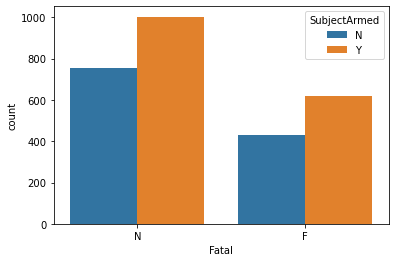

<IPython.core.display.Javascript object>

In [23]:
sns.countplot(x=subject_armed_df["Fatal"], hue=subject_armed_df["SubjectArmed"])
plt.show()

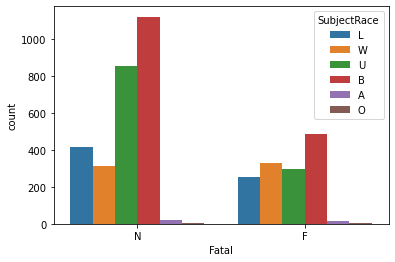

<IPython.core.display.Javascript object>

In [24]:
sns.countplot(x=df["Fatal"], hue=df["SubjectRace"])
plt.show()

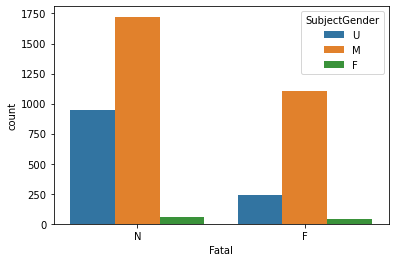

<IPython.core.display.Javascript object>

In [25]:
sns.countplot(x=df["Fatal"], hue=df["SubjectGender"])
plt.show()

In [26]:
language_df["Fatal"].value_counts()

N     2719
F     1379
U      288
 N      11
 F       3
Name: Fatal, dtype: int64

<IPython.core.display.Javascript object>

In [27]:
language_df["Fatal"] = language_df["Fatal"].replace(
    {"N": 0, "F": 1, "U": 0, " N": 0, " F": 1}
)

<IPython.core.display.Javascript object>

In [28]:
fatal_lang = language_df[language_df["Fatal"] == 1]
non_fatal_lang = language_df[language_df["Fatal"] == 0]

<IPython.core.display.Javascript object>

In [29]:
fatal_lang.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382 entries, 1 to 4399
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Fatal          1382 non-null   int64 
 1   NatureOfStop   606 non-null    object
 2   FullNarrative  742 non-null    object
 3   Notes          718 non-null    object
dtypes: int64(1), object(3)
memory usage: 54.0+ KB


<IPython.core.display.Javascript object>

In [30]:
fatallang = fatal_lang["FullNarrative"].dropna()
nonfatal_lang = non_fatal_lang["FullNarrative"].dropna()

<IPython.core.display.Javascript object>

In [31]:
from wordcloud import WordCloud

<IPython.core.display.Javascript object>

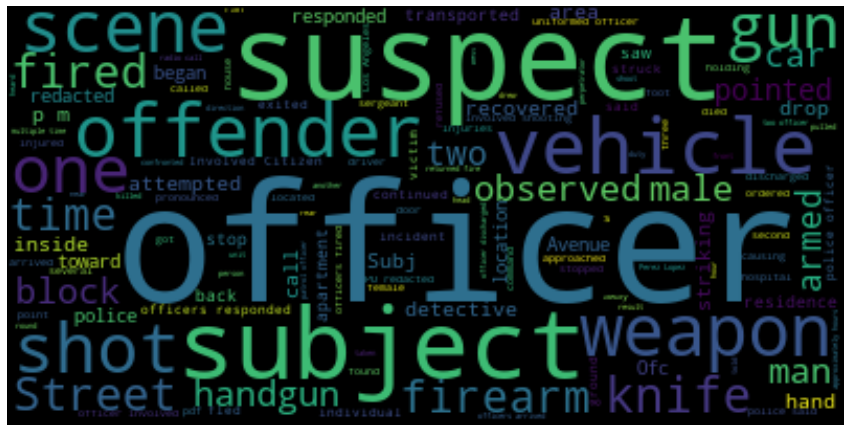

<IPython.core.display.Javascript object>

In [32]:
wordcloud = WordCloud(background_color="black").generate(" ".join(fatallang))
plt.figure(figsize=(15, 10))
# Display the generated image
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

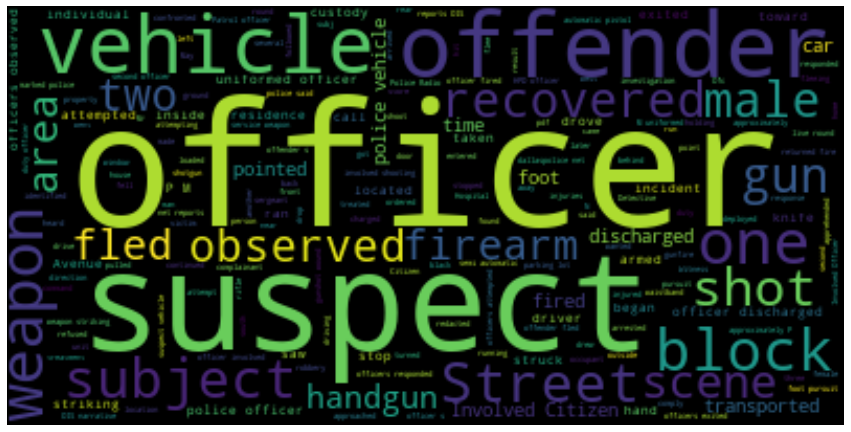

<IPython.core.display.Javascript object>

In [33]:
wordcloud = WordCloud(background_color="black").generate(" ".join(nonfatal_lang))
plt.figure(figsize=(15, 10))
# Display the generated image
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [34]:
df["Fatal"] = df["Fatal"].replace({"N": 0, "F": 1, "U": 0, " N": 0, " F": 1})

<IPython.core.display.Javascript object>

In [35]:
fatal_df = df[df["Fatal"] == 1]
unfatal_df = df[df["Fatal"] == 0]

<IPython.core.display.Javascript object>

In [36]:
subject_armed_df = df[df["SubjectArmed"] == "Y"]

<IPython.core.display.Javascript object>

In [37]:
subject_notarmed_df = df[df["SubjectArmed"] == "N"]

<IPython.core.display.Javascript object>

In [38]:
subject_armed_df["Fatal"].value_counts()

0    1003
1     621
Name: Fatal, dtype: int64

<IPython.core.display.Javascript object>

In [39]:
ft_sm = subject_armed_df["Fatal"].value_counts().sum()
(subject_armed_df["Fatal"].value_counts()[1]) / ft_sm

0.38238916256157635

<IPython.core.display.Javascript object>

In [40]:
na_sum = subject_notarmed_df["Fatal"].value_counts().sum()

<IPython.core.display.Javascript object>

In [41]:
subject_notarmed_df["Fatal"].value_counts()[1] / na_sum

0.3642495784148398

<IPython.core.display.Javascript object>

In [42]:
subject_notarmed_df["Fatal"].value_counts()

0    754
1    432
Name: Fatal, dtype: int64

<IPython.core.display.Javascript object>

## Shots DF

In [43]:
# Find and drop Unkown number of shots
unknown_shots = shots_df[shots_df["Total_shots"] == "U"].index
shots_df = shots_df.drop(unknown_shots)

<IPython.core.display.Javascript object>

In [44]:
# Convert Subject age to numbers
shots_df["SubjectAge"] = pd.to_numeric(shots_df["SubjectAge"], errors="coerce")

# Fill Na's with mean age
mean_age = round(shots_df["SubjectAge"].mean(), 0)
shots_df["SubjectAge"].fillna(mean_age, inplace=True)

<IPython.core.display.Javascript object>

In [45]:
# Convert Total Shots to numeric
shots_df["Total_shots"] = pd.to_numeric(shots_df["Total_shots"])

<IPython.core.display.Javascript object>

In [46]:
# Convert Fatal column to numeric
shots_df["Fatal"] = shots_df["Fatal"].replace({"N": 0, "F": 1})

<IPython.core.display.Javascript object>

In [47]:
# Change values to numeric, classifying 'U' the same as
# 'N' because if they dont know if the subject was armed
# Then for our purposes this is the same as the subject not
# being armed
shots_df["SubjectArmed"].replace({"N": 0, "Y": 1, "U": 0}, inplace=True)

<IPython.core.display.Javascript object>

In [48]:
# Find the one missing value for Number of Officers
missing_officer_num = shots_df[shots_df["NumberOfOfficers"].isna()].index

<IPython.core.display.Javascript object>

In [49]:
# Drop that value, since there is a lot of other missing info
# From that row
shots_df.drop(missing_officer_num, inplace=True)

<IPython.core.display.Javascript object>

In [50]:
# shots_df[shots_df["NumberOfOfficers"] == "U"]
shots_df["NumberOfOfficers"].replace("U", 1, inplace=True)

<IPython.core.display.Javascript object>

In [51]:
# Convert Number of Officers to numeric
shots_df["NumberOfOfficers"] = pd.to_numeric(shots_df["NumberOfOfficers"])

<IPython.core.display.Javascript object>

In [52]:
# Convert age to log for normalization
shots_df["log_SubjectAge"] = np.log(shots_df["SubjectAge"])

<IPython.core.display.Javascript object>

In [53]:
# Drop columns that are not of interest
shots_df = shots_df.drop(
    columns=[
        "Month",
        "officer_U",
        "Other Race Officer Involved",
        "Female Officer Present",
        "races_split",
        "Officer Genders",
        "Year",
        "Department",
        "SubjectAge",
        "City",
        "OfficerGender",
    ]
)

<IPython.core.display.Javascript object>

In [54]:
# Creating Interaction variable for instances where there is a White Officer and Black Suspect

shots_df["W_officer_B_Subject"] = 0

shots_df.loc[
    (shots_df["White Officer Involved"] == 1) & (shots_df["SubjectRace"] == "B"),
    "W_officer_B_Subject",
] = 1

<IPython.core.display.Javascript object>

## No Shots DF

In [55]:
# Drop Total Shots from this DataFrame
no_shots_df = no_shots_df.drop(columns="Total_shots")

<IPython.core.display.Javascript object>

In [56]:
# Convert Target variable to binary numeric
no_shots_df["Fatal"].replace(
    {
        "N": 0,
        "F": 1,
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

In [57]:
# no_shots_df[no_shots_df["NumberOfOfficers"] == "U"]
no_shots_df["NumberOfOfficers"].replace({"U": 1}, inplace=True)

no_shots_df["NumberOfOfficers"] = pd.to_numeric(no_shots_df["NumberOfOfficers"])

<IPython.core.display.Javascript object>

In [58]:
no_shots_df = no_shots_df.drop(columns="OfficerGender")

<IPython.core.display.Javascript object>

In [59]:
no_shots_df["SubjectAge"] = pd.to_numeric(no_shots_df["SubjectAge"], errors="coerce")

# Fill Na's with mean subject age

mean_age = round(no_shots_df["SubjectAge"].mean(), 0)
no_shots_df["SubjectAge"].fillna(mean_age, inplace=True)

<IPython.core.display.Javascript object>

In [60]:
# Drop remaining NA's
no_shots_df = no_shots_df.dropna()

<IPython.core.display.Javascript object>

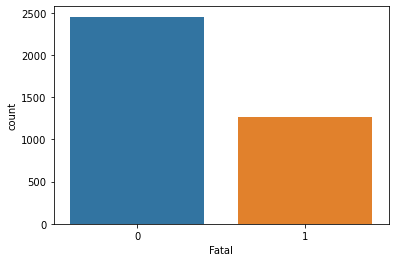

<IPython.core.display.Javascript object>

In [61]:
# Fatality Count Plot
sns.countplot(x=no_shots_df["Fatal"])
plt.show()

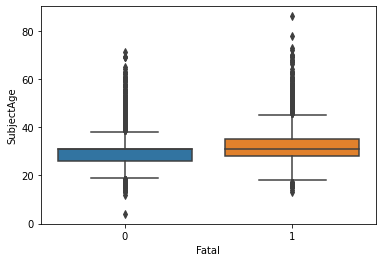

<IPython.core.display.Javascript object>

In [62]:
# Fatality by Subject Age
sns.boxplot(x=no_shots_df["Fatal"], y=no_shots_df["SubjectAge"], data=no_shots_df)
plt.show()

In [63]:
# create Log Subject age for Normalization
no_shots_df["log_SubjectAge"] = np.log(no_shots_df["SubjectAge"])

<IPython.core.display.Javascript object>

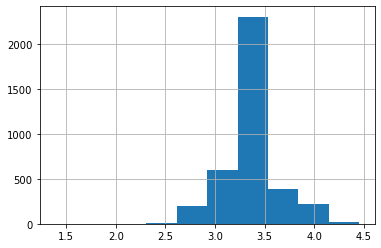

<IPython.core.display.Javascript object>

In [64]:
# Histogram of Log Subject age
no_shots_df["log_SubjectAge"].hist()
plt.show()

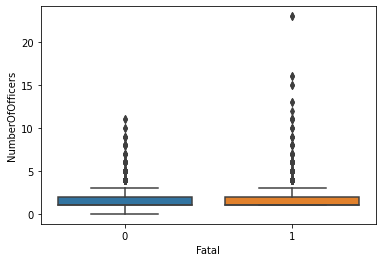

<IPython.core.display.Javascript object>

In [65]:
# Box Plots of Fatality and Number of officers
sns.boxplot(x=no_shots_df["Fatal"], y=no_shots_df["NumberOfOfficers"], data=no_shots_df)
plt.show()

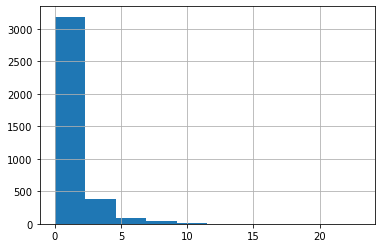

<IPython.core.display.Javascript object>

In [66]:
# Number of officers histogram
no_shots_df["NumberOfOfficers"].hist()
plt.show()

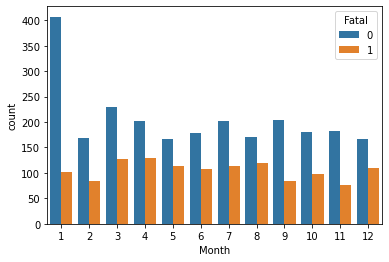

<IPython.core.display.Javascript object>

In [67]:
# Monthly Fatalities
sns.countplot(x="Month", hue="Fatal", data=no_shots_df)
plt.show()

In [68]:
# Drop columns that are not of interest
drop_cols = [
    "Department",
    "City",
    "Year",
    "Month",
    "races_split",
    "officer_U",
    "Officer Genders",
]

no_shots_df = no_shots_df.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

## Models

### Model Prep

In [69]:
# shots_df.info()

<IPython.core.display.Javascript object>

In [70]:
# Reset and drop index
shots_df.reset_index(drop=True, inplace=True)
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Fatal                    1138 non-null   int64  
 1   SubjectArmed             1138 non-null   int64  
 2   SubjectRace              1138 non-null   object 
 3   SubjectGender            1138 non-null   object 
 4   NumberOfOfficers         1138 non-null   int64  
 5   White Officer Involved   1138 non-null   int64  
 6   Latino Officer Involved  1138 non-null   int64  
 7   Black Officer Involved   1138 non-null   int64  
 8   Asian Officer Involve    1138 non-null   int64  
 9   Male Officer Present     1138 non-null   int64  
 10  Total_shots              1138 non-null   int64  
 11  log_SubjectAge           1138 non-null   float64
 12  W_officer_B_Subject      1138 non-null   int64  
dtypes: float64(1), int64(10), object(2)
memory usage: 115.7+ KB


<IPython.core.display.Javascript object>

In [71]:
# Manually get dummies for categorical variables and drop
# Original columns
shots_df = shots_df.join(pd.get_dummies(shots_df[["SubjectRace", "SubjectGender"]]))
shots_df = shots_df.drop(
    columns=["SubjectRace", "SubjectGender", "SubjectRace_U", "SubjectGender_U"]
)

<IPython.core.display.Javascript object>

In [72]:
# Sort features
bin_cols = [
    "SubjectGender",
    "SubjectArmed",
    "White Officer Involved",
    "Latino Officer Involved",
    "Black Officer Involved",
    "Asian Officer Involve",
    "Male Officer Present",
]

num_cols = ["log_SubjectAge", "NumberOfOfficers", "Total_shots"]

cat_cols = ["SubjectRace", "SubjectGender"]
drop_cats = ["U", "U"]

<IPython.core.display.Javascript object>

In [73]:
# Print VIF and inspect for multicolinearity. Dropped
# Variables that had value of 8 or higher
print_vif(shots_df)

VIF results
-------------------------------
const                      172.279659
Fatal                        1.145271
SubjectArmed                 1.070709
NumberOfOfficers             1.505855
White Officer Involved       2.795859
Latino Officer Involved      1.138382
Black Officer Involved       1.299653
Asian Officer Involve        1.054228
Male Officer Present         1.404095
Total_shots                  1.507370
log_SubjectAge               1.140452
W_officer_B_Subject          3.196434
SubjectRace_A                1.081800
SubjectRace_B                3.263891
SubjectRace_L                2.248276
SubjectRace_W                2.406290
SubjectGender_F              1.141129
SubjectGender_M              1.323556
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [74]:
# Set Target and independant variables
X = shots_df.drop(columns="Fatal")
y = shots_df["Fatal"]

# Train, Test, Split data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

<IPython.core.display.Javascript object>

### SVM

In [75]:
# Create Preprocessing
preprocessing = ColumnTransformer(
    [
        #        ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [76]:
# Create SVC Pipeline
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", SVC()),
    ]
)

<IPython.core.display.Javascript object>

In [77]:
# Create Grid, run models, close in on best parameters
grid = {
    "model__C": np.arange(0.1, 0.5, 0.1),
    "model__kernel": ["rbf", "linear", "poly"],
}

<IPython.core.display.Javascript object>

In [78]:
# Perform Gridsearch
pipeline_cv = GridSearchCV(pipeline, grid, verbose=2, n_jobs=-1)

<IPython.core.display.Javascript object>

In [79]:
pipeline_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.2s finished


GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['log_SubjectAge',
                                                                          'NumberOfOfficers',
                                                                          'Total_shots'])])),
                                       ('model', SVC())]),
             n_jobs=-1,
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4]),
                         'model__kernel': ['rbf', 'linear', 'poly']},
             verbose=2)

<IPython.core.display.Javascript object>

In [80]:
# Print SVC Scores
svm_train_score = pipeline_cv.score(X_train, y_train)
svm_test_score = pipeline_cv.score(X_test, y_test)

print(svm_train_score, svm_test_score)

0.6868131868131868 0.6842105263157895


<IPython.core.display.Javascript object>

In [81]:
# Find best parameters, then edit grid to close in on best
# Overall parameters
best_params = pipeline_cv.best_params_
best_params

{'model__C': 0.30000000000000004, 'model__kernel': 'linear'}

<IPython.core.display.Javascript object>

In [82]:
# Make predictions
y_pred = pipeline_cv.predict(X_test)
# Create Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_fatal", "actual_not_fatal"],
    columns=["pred_fatal", "pred_not_fatal"],
)

confusion_df

,pred_fatal,pred_not_fatal
actual_fatal,114,27
actual_not_fatal,45,42


<IPython.core.display.Javascript object>

### Random Forest

In [83]:
# Isolate target variables and independant features,
# Perform Train, test, split
X = shots_df.drop(columns="Fatal")
y = shots_df["Fatal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

<IPython.core.display.Javascript object>

In [84]:
# Set preprocessing
preprocessing = ColumnTransformer(
    [
        #        ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [85]:
# Create Random Forest pipeline
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", RandomForestClassifier()),
    ]
)

<IPython.core.display.Javascript object>

In [86]:
# Fit and score initial Random Forest Model
pipeline.fit(X_train, y_train)

model_0_train_score = pipeline.score(X_train, y_train)
model_0_test_score = pipeline.score(X_test, y_test)

print(model_0_train_score, model_0_test_score)

0.9615384615384616 0.6798245614035088


<IPython.core.display.Javascript object>

In [87]:
# Create grid, close in on best parameters
grid = {
    "model__n_estimators": [50, 100, 1000],
    "model__max_depth": [10, 50, 500],
    "model__min_samples_leaf": [5, 10, 50],
}

<IPython.core.display.Javascript object>

In [88]:
# Perform grid Search
pipeline_cv = GridSearchCV(pipeline, grid, cv=5, verbose=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   20.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['log_SubjectAge',
                                                                          'NumberOfOfficers',
                                                                          'Total_shots'])])),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 50, 500],
                         'model__min_samples_leaf': [5, 10, 50],
                         'model__n_estimators': [50, 100, 1000]},
             verbose=2)

<IPython.core.display.Javascript object>

In [89]:
# Find best parameters, then go back and edit grid to
# close in on best parameters
best_params = pipeline_cv.best_params_
best_params

{'model__max_depth': 500,
 'model__min_samples_leaf': 5,
 'model__n_estimators': 1000}

<IPython.core.display.Javascript object>

In [90]:
# Print Random Forest Train and test scores
rfc_train_score = pipeline_cv.score(X_train, y_train)
rfc_test_score = pipeline_cv.score(X_test, y_test)

print(rfc_train_score, rfc_test_score)

0.7791208791208791 0.6754385964912281


<IPython.core.display.Javascript object>

In [91]:
# Make predictions, then make confusion matrix
y_pred = pipeline_cv.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_fatal", "actual_not_fatal"],
    columns=["pred_fatal", "pred_not_fatal"],
)

confusion_df

,pred_fatal,pred_not_fatal
actual_fatal,109,21
actual_not_fatal,53,45


<IPython.core.display.Javascript object>

In [92]:
# Create and Print Feature importances
feature_importances = pipeline_cv.best_estimator_["model"].feature_importances_
feature_importances = pd.DataFrame(
    {"feature": X_train.columns, "importance": feature_importances}
).sort_values("importance", ascending=False)
feature_importances

,feature,importance
0,SubjectArmed,0.275715
2,White Officer Involved,0.214674
1,NumberOfOfficers,0.136458
13,SubjectRace_W,0.077891
15,SubjectGender_M,0.052232
11,SubjectRace_B,0.044404
3,Latino Officer Involved,0.042935
4,Black Officer Involved,0.037206
8,log_SubjectAge,0.034460
6,Male Officer Present,0.025613


<IPython.core.display.Javascript object>

### XGBoost

In [93]:
# Create Pipeline, using same train, test, split as
# previous models
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", XGBClassifier()),
    ]
)

<IPython.core.display.Javascript object>

In [94]:
# Create Grid, run model until close in on best params,
# Commented out previous attempts
grid = {
    "model__n_estimators": np.arange(1, 3),
    "model__learning_rate": np.arange(0, 50, 10),
    "model__colsample_bytree": np.arange(0.7, 1, 0.1),
    #    "model__max_depth": np.arange(4, 7),
    "model__max_depth": [6],
}

<IPython.core.display.Javascript object>

In [95]:
# Perform Grid Search
pipeline_cv = GridSearchCV(pipeline, grid, cv=5, verbose=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.5s


[12:55:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.9s finished
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['log_SubjectAge',
                                                                          'NumberOfOfficers',
                                                                          'Total_shots'])])),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                             

<IPython.core.display.Javascript object>

In [96]:
# Find best perameters, edit grid ^
best_params = pipeline_cv.best_params_
best_params

{'model__colsample_bytree': 0.9999999999999999,
 'model__learning_rate': 10,
 'model__max_depth': 6,
 'model__n_estimators': 1}

<IPython.core.display.Javascript object>

In [97]:
# Calculate and print XGB scores
xgb_train_score = pipeline_cv.score(X_train, y_train)
xgb_test_score = pipeline_cv.score(X_test, y_test)

print(xgb_train_score, xgb_test_score)

0.7593406593406593 0.6140350877192983


<IPython.core.display.Javascript object>

In [98]:
# Determine feature important and convert to Dataframe
feature_importances = pipeline_cv.best_estimator_["model"].feature_importances_
feature_importances = pd.DataFrame(
    {"feature": X_train.columns, "importance": feature_importances}
).sort_values("importance", ascending=False)
feature_importances

,feature,importance
1,NumberOfOfficers,0.219324
15,SubjectGender_M,0.154712
13,SubjectRace_W,0.146592
0,SubjectArmed,0.121170
2,White Officer Involved,0.068644
11,SubjectRace_B,0.063246
5,Asian Officer Involve,0.051420
3,Latino Officer Involved,0.049582
9,W_officer_B_Subject,0.040442
6,Male Officer Present,0.039488


<IPython.core.display.Javascript object>

In [99]:
# Run Predictions and make DataFrame
y_preds = pipeline_cv.predict(X_test)
preds_df, fig = predictions_df(X_test, y_test, y_preds)

# Create A Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_preds)
confusion_df = pd.DataFrame(
    cm,
    index=["actual_fatal", "actual_not_fatal"],
    columns=["pred_fatal", "pred_not_fatal"],
)


cr = classification_report(y_test, y_preds)
print(cr)


pred_prob = pipeline_cv.predict_proba(X_test)
# add prediction probs to preds_df
preds_df["pred_prob"] = pred_prob[:, 1]

preds_df = preds_df.drop(columns=["residuals", "abs_residuals"])
# preds_df.head()

              precision    recall  f1-score   support

           0       0.64      0.74      0.69       130
           1       0.56      0.45      0.50        98

    accuracy                           0.61       228
   macro avg       0.60      0.59      0.59       228
weighted avg       0.61      0.61      0.61       228



<IPython.core.display.Javascript object>

In [100]:
confusion_df

,pred_fatal,pred_not_fatal
actual_fatal,96,34
actual_not_fatal,54,44


<IPython.core.display.Javascript object>

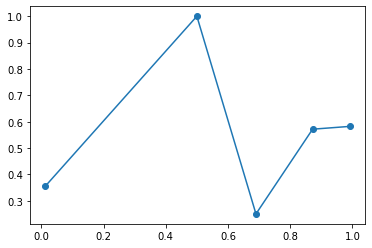

<IPython.core.display.Javascript object>

In [101]:
# Calculate Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, pred_prob[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true, "-o")
plt.show()

### Logistic Regression 

In [102]:
# Run train, test split for Logistic Regression model
X = shots_df.drop(columns="Fatal")
y = shots_df["Fatal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

<IPython.core.display.Javascript object>

In [103]:
# Create Pipeline
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", LogisticRegression()),
    ]
)

<IPython.core.display.Javascript object>

In [104]:
# Create grid
grid = {
    #    "model__C": [0.1, 1, 5, 10],
    "model__C": [1, 1.5, 2, 2.5],
    "model__solver": ["newton-cg", "lbfgs", "sag", "saga"],
    #    "model__solver": ["newton-cg"],
}

<IPython.core.display.Javascript object>

In [105]:
# Fit pipeline
pipeline_cv = GridSearchCV(pipeline, grid, cv=5, verbose=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['log_SubjectAge',
                                                                          'NumberOfOfficers',
                                                                          'Total_shots'])])),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [1, 1.5, 2, 2.5],
                         'model__solver': ['newton-cg', 'lbfgs', 'sag',
                                           'saga']},
             verbose=2)

<IPython.core.display.Javascript object>

In [106]:
# Find and print train and test score for Logistic Regression
lr_train_score = pipeline_cv.score(X_train, y_train)
lr_test_score = pipeline_cv.score(X_test, y_test)

print(lr_train_score, lr_test_score)

0.6956043956043956 0.6929824561403509


<IPython.core.display.Javascript object>

In [107]:
# Determine best parameters
best_params = pipeline_cv.best_params_
best_params

{'model__C': 1, 'model__solver': 'newton-cg'}

<IPython.core.display.Javascript object>

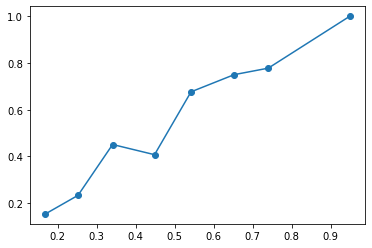

<IPython.core.display.Javascript object>

In [108]:
# Predict proababilty
pred_prob = pipeline_cv.predict_proba(X_test)

# Create and print calibration curve
prob_true, prob_pred = calibration_curve(y_test, pred_prob[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true, "-o")
plt.show()

In [109]:
# Make predictions
preds = pipeline_cv.predict(X_test)

# create Predictions DataFrame
preds_df, _ = predictions_df(X_test, y_test, preds)
preds_df["pred_prob"] = pred_prob[:, 1]
preds_df = preds_df.drop(columns=["residuals", "abs_residuals"])

# Create and Print Confusion Matrix/ Classification Report
cm = confusion_matrix(y_test, preds)
confusion_df = pd.DataFrame(
    cm,
    index=["actual_fatal", "actual_not_fatal"],
    columns=["pred_fatal", "pred_not_fatal"],
)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76       130
           1       0.72      0.47      0.57        98

    accuracy                           0.69       228
   macro avg       0.70      0.67      0.66       228
weighted avg       0.70      0.69      0.68       228



<IPython.core.display.Javascript object>

In [110]:
confusion_df

,pred_fatal,pred_not_fatal
actual_fatal,112,18
actual_not_fatal,52,46


<IPython.core.display.Javascript object>

## Models Performances

In [111]:
scores = {
    "Support Vector Machines": [svm_train_score, svm_test_score],
    "Random Forest Classifier": [model_0_train_score, model_0_test_score],
    "XGBoost Classifier": [xgb_train_score, xgb_test_score],
    "Logistic Regression": [lr_train_score, lr_test_score],
}

ind = ["Train Score", "Test Score"]

model_performance = pd.DataFrame(scores, index=ind)

<IPython.core.display.Javascript object>

In [112]:
model_performance

,Support Vector Machines,Random Forest Classifier,XGBoost Classifier,Logistic Regression
Train Score,0.686813,0.961538,0.759341,0.695604
Test Score,0.684211,0.679825,0.614035,0.692982


<IPython.core.display.Javascript object>

In my opinion, the best model performance was that of the Logistic regression. Although it did not have the largest training score, it did not over fit like the rest of the models and returned a consistent accuracy of about 70%. The Calibration curve of the logistic regression model was also the only one of the models that was close to a linear line, which would be an optimal calibration. 